##**Bài 1:** Cho bài toán XOR
- Implement thuật toán neural network để giải bài toán dùng Pytorch

In [4]:
import torch
import torch.optim as optim

# Hàm kích hoạt sigmoid
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# Lớp neural network
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.weights = [torch.randn(layers[i], layers[i+1], requires_grad=True) for i in range(len(layers) - 1)]
        self.biases = [torch.zeros(1, layers[i+1], requires_grad=True) for i in range(len(layers) - 1)]

    def forward(self, x):
        for i in range(len(self.layers) - 2):
            x = sigmoid(torch.mm(x, self.weights[i]) + self.biases[i])
        x = torch.mm(x, self.weights[-1]) + self.biases[-1]
        return x

# Hàm loss
def bce_with_logits(logits, labels):
    return torch.mean(torch.clamp(logits, 0) - logits * labels + torch.log(1 + torch.exp(-torch.abs(logits))))

In [5]:
# Dữ liệu mẫu XOR
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

# Tạo mạng neural network với 2 lớp ẩn và 1 lớp đầu ra
model = NeuralNetwork([2, 2, 1])

# Optimizer
optimizer = optim.SGD([{'params': model.weights, 'lr': 0.1}, {'params': model.biases, 'lr': 0.1}], lr=0.1)

# Huấn luyện mô hình
for epoch in range(10000):
    # Forward pass
    outputs = model.forward(X)

    # Tính loss
    loss = bce_with_logits(outputs, y)

    # Backpropagation và cập nhật trọng số
    optimizer.zero_grad()
    loss.backward()

    # Cập nhật trọng số và bias
    for param in model.weights + model.biases:
        param.data -= 0.1 * param.grad

    if epoch % 1000 == 0:
        print(f'Epoch [{epoch + 1}/10000], Loss: {loss.item()}')

# Dự đoán
with torch.no_grad():
    predictions = model.forward(X)
    predictions = (predictions > 0).float()  # Sử dụng ngưỡng 0 để phân loại

print("Predictions:")
print(predictions)

Epoch [1/10000], Loss: 0.7326961755752563
Epoch [1001/10000], Loss: 0.6925710439682007
Epoch [2001/10000], Loss: 0.6873793601989746
Epoch [3001/10000], Loss: 0.6347977519035339
Epoch [4001/10000], Loss: 0.5399348139762878
Epoch [5001/10000], Loss: 0.47398367524147034
Epoch [6001/10000], Loss: 0.261616587638855
Epoch [7001/10000], Loss: 0.10008591413497925
Epoch [8001/10000], Loss: 0.05427705496549606
Epoch [9001/10000], Loss: 0.036203984171152115
Predictions:
tensor([[0.],
        [1.],
        [1.],
        [0.]])


##**Bài 2:**
Cho dataset MNIST
- Implement thuật toán neural network với dữ liệu trên sử dụng Pytorch
- Chỉnh learning rate, vẽ đồ thị loss tương ứng.
- Chia tập train/test tỉ lệ 80/20, tính các chỉ số MSE, RSME, MAE, MAPE trên tập test.


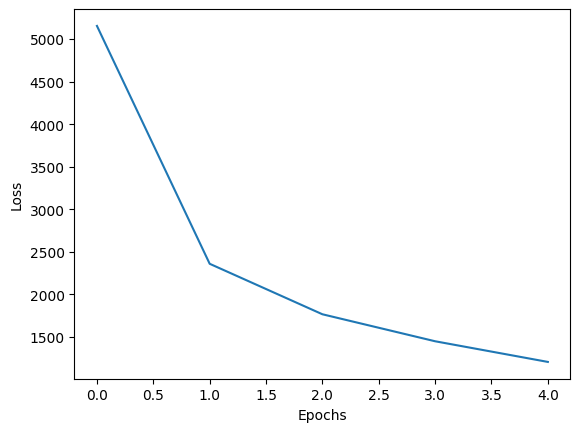

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Tải dữ liệu MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Chia tập train và test (80/20)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

# Định nghĩa mạng neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Định nghĩa hàm mất mát và bộ tối ưu hóa
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Huấn luyện mạng
loss_values = []
for epoch in range(5):  # Chạy 5 epochs để minh họa
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss_values.append(running_loss)

# Vẽ đồ thị loss
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Đánh giá mạng trên tập test
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()



In [7]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
import numpy as np

true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print('Accuracy on test data: {:.2%}'.format(accuracy))
print('Weighted Recall on test data: {:.2%}'.format(recall))
print('Weighted F1-score on test data: {:.2%}'.format(f1))

Accuracy on test data: 96.78%
Weighted Recall on test data: 96.78%
Weighted F1-score on test data: 96.78%


##**Bài 3:**
Tại sao hàm softmax lại dùng exponential function (e) mà không phải số khác như 2, 3 hoặc 4


Hàm softmax sử dụng hàm exponential function (e) vì nó có một số tính chất phù hợp với việc tạo ra phân phối xác suất. Cụ thể, hàm exponential function có các tính chất sau:

- Số dương: Giá trị của hàm exponential function luôn là dương. Điều này đảm bảo rằng các giá trị đầu ra của hàm softmax cũng là dương, phù hợp với phân phối xác suất.
- Tăng nhanh: Giá trị của hàm exponential function tăng nhanh khi giá trị của đối số tăng. Điều này đảm bảo rằng các giá trị đầu ra của hàm softmax có thể phân biệt được, phù hợp với việc phân loại các đối tượng thành các lớp khác nhau.
- Tổng bằng 1: Tổng của các giá trị của hàm exponential function với cùng một đối số bằng 1. Điều này đảm bảo rằng tổng của các giá trị đầu ra của hàm softmax bằng 1, phù hợp với phân phối xác suất.

Nếu sử dụng một số khác như 2, 3 hoặc 4 thay vì e cho hàm softmax, các tính chất quan trọng này sẽ không được đảm bảo, và việc sử dụng hàm softmax sẽ không còn phù hợp cho bài toán phân phối xác suất.